In [1]:
import gc
import math
import pickle
import random
import itertools
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

# Initial Data Load
Load in all of the subject IDs, Assignments, and CodeStateIDs. Also load in the grades and scores for each of the subjects and code states. 

In [3]:
# Load final exam and assignment data
data = pd.DataFrame(columns=['SubjectID', 'Assignment', 'CodeStateID'])
grades = {}
scores = {}
total_non_compile = 0
data_dir = Path.cwd() / '..' / 'data'
for directory in [data_dir / 'F19_All' / 'Train', data_dir / 'S19_All']:
    grade_data = pd.read_csv(directory / 'Data' / 'LinkTables' / 'Subject.csv')
    for row in grade_data.itertuples():
        grades[row.SubjectID] = row._2 if directory.name == 'S19_All' else row._2 / 100
    main = pd.read_csv(directory / 'Data' / 'MainTable.csv')
    total_non_compile += len(main['CodeStateID'].unique())
    for row in main[main['EventType'] == 'Run.Program'].itertuples():
        scores[row.CodeStateID] = row.Score
    main['Assignment'] = [f'{int(x[0])}-{int(x[1])}' for x in list(zip(main['AssignmentID'], main['ProblemID']))]
    data = pd.concat([data, main[['SubjectID', 'Assignment', 'CodeStateID']]], ignore_index=True)

data['Score'] = [scores[x] for x in data['CodeStateID']]
data['ExamGrade'] = [grades[x] if x in grades else 0 for x in data['SubjectID']]
data.head()

print(f'ALL Programs: {total_non_compile}')

ALL Programs: 161378


In [4]:
# Find the Code IDs for the submissions with the highest score for each student for each assignment
students = list(data['SubjectID'].unique())
assignments = data['Assignment'].unique()
best_score_data = {}
num_null_submissions = 0
for student in students:
    best_ids = [None] * len(assignments)
    s_filter = data[data['SubjectID'] == student]
    a_idx = 0
    for assignment in assignments:
        a_filter = s_filter[s_filter['Assignment'] == assignment].reset_index()
        if len(a_filter.index) > 0:
            best_ids[a_idx] = a_filter['CodeStateID'][np.argmax(a_filter['Score'])]
        else:
            num_null_submissions += 1
        a_idx += 1
    best_score_data[student] = best_ids
best_score_data[students[0]][0:5]

print(f"TOTAL Number of submissions: {len(data.index)}")
# Free some memory
del scores
del data
gc.collect()

print(f"Number of Students: {len(students)}")
print(f"Number of student-assignment pairs: {len(students) * len(assignments)}")
print(f"Number of assignment-student pairs with no submissions: {num_null_submissions}")

TOTAL Number of submissions: 463968
Number of Students: 780
Number of student-assignment pairs: 39000
Number of assignment-student pairs with no submissions: 5143


Train avg: 0.59 Test avg: 0.61
Train dev: 0.26 Test dev: 0.20
Train


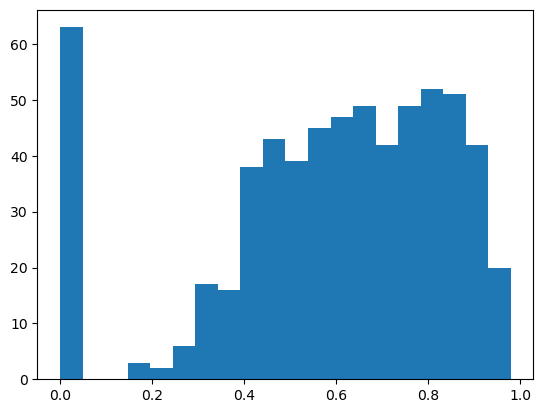

Number of students: 624
Missing Grades: 38
Test


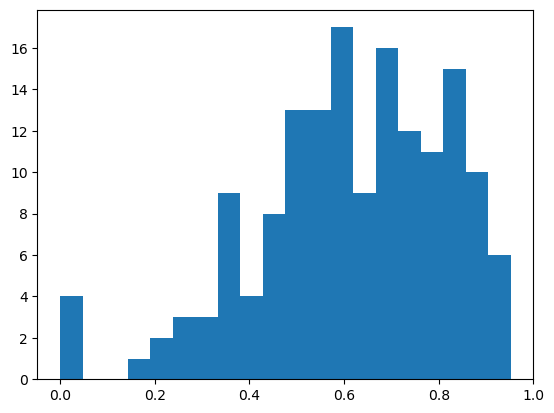

Number of students: 156
Missing Grades: 3


In [5]:
# Divide data into 80% training data, 20% testing data
random.seed(3774713)
num_students = len(students)
test_students = set(random.sample(students, int(num_students * 0.2)))
train_students = set([x for x in students if x not in test_students])

missing_test_grades = 0
missing_train_grades = 0

test_grades = []
for x in test_students:
    if x in grades:
        test_grades.append(grades[x])
    else:
        test_grades.append(0)
        missing_test_grades += 1

train_grades = []
for x in train_students:
    if x in grades:
        train_grades.append(grades[x])
    else:
        train_grades.append(0)
        missing_train_grades += 1

print(f'Train avg: {np.mean(train_grades):0.2f} Test avg: {np.mean(test_grades):0.2f}')
print(f'Train dev: {np.std(train_grades):0.2f} Test dev: {np.std(test_grades):0.2f}')

# test_ids = set([x in test_students for x in students])
# train_ids = set([x in train_students for x in students])
print('Train')
plt.hist(train_grades, bins=20)
plt.show()
print(f'Number of students: {len(train_students)}')
print(f'Missing Grades: {missing_train_grades}')

print('Test')
plt.hist(test_grades, bins=20)
plt.show()
print(f'Number of students: {len(test_students)}')
print(f'Missing Grades: {missing_test_grades}')

In [6]:
# code_states = {}
# for directory in ['F19_All', 'S19_All']:
#   base_path = os.path.join('data', directory, 'Train' if directory == 'F19_All' else '')
#   code_data = pd.read_csv(os.path.join(base_path, 'Data', 'CodeStates', 'CodeStates.csv'))
#   for row in code_data.itertuples():
#     code_states[row.CodeStateID] = row.Code

In [7]:
# random.seed(1)
# validation_set = set(random.sample(list(code_states.keys()), int(len(code_states) / 10)))
# for c_id in train_data['CodeStateID'].unique():
#   directory = 'Validate' if c_id in validation_set else 'Train' 
#   with open(os.path.join(directory, c_id + '.java'), 'w', encoding="utf-8") as f:
#     print(code_states[c_id], file=f)

In [8]:
# for c_id in test_data['CodeStateID'].unique():
#   with open(os.path.join('Test', c_id + '.java'), 'w', encoding="utf-8") as f:
#     print(code_states[c_id], file=f)

In [9]:
# Given a dataframe, a vector length, and a number of components,
# Divide all the vectors into a train and test set and transform them using PCA with the given number of components
def train_test_vectors(df, vector_length, lstr):
    train_X = []
    train_y = []
    test_X = []
    test_y = []
    vector_lookup = {}
    num_missing = 0
    total_train_sub = 0
    total_test_sub = 0
    for idx, row in df.iterrows():
        vector = np.array(row[0:vector_length])
        vector_lookup[row['CodeStateID'][len(lstr):]] = vector
    for student in students:
        all_assign = []
        num_present = 0
        for x in best_score_data[student]:
            if x in vector_lookup:
                all_assign.append(vector_lookup[x])
                num_present += 1
            else:
                num_missing += 1
                all_assign.append(np.zeros(vector_length))
        all_assign = np.concatenate(all_assign)
        if student in train_students:
            train_X.append(all_assign)
            train_y.append(grades[student] if student in grades else 0)
            total_train_sub += num_present
        elif student in test_students:
            test_X.append(all_assign)
            test_y.append(grades[student] if student in grades else 0)
            total_test_sub += num_present
    #   pca = PCA(n_components=n_components, random_state=1)
    #   train_X = pca.fit_transform(train_X)
    #   test_X = pca.transform(test_X)
    print(f'Missing {num_missing} vectors')
    print(f'Train vectors: {total_train_sub}')
    print(f'Test vectors: {total_test_sub}')
    return train_X, train_y, test_X, test_y

In [10]:
def tune_model(name, model, parameters, n_iter):
    pipeline = Pipeline(steps=[('pca', PCA(random_state=1)), ('model', model)])
    if name in saved_models:
        pipeline.set_params(**saved_models[name])
    else:
        new_params = {'pca__n_components': parameters['n_components']}
        for key in parameters:
            if key != 'n_components':
                new_params['model__' + key] = parameters[key]
        cv = RandomizedSearchCV(pipeline, new_params, random_state=1, scoring='neg_mean_absolute_error', n_iter=n_iter,
                                verbose=2)
        cv.fit(train_X, train_y)
        saved_models[name] = cv.best_params_
        with open('saved_models', 'wb') as f:
            pickle.dump(saved_models, f)
        pipeline.set_params(**cv.best_params_)
    #   print("Variance captured: %0.3f" % np.sum(pipeline.steps[0].explained_variance_ratio_))
    return pipeline

In [11]:

if not (Path.cwd() / 'saved_models').exists():
    with open('saved_models', 'wb') as f:
        pickle.dump(dict(), f)

In [12]:
with open('saved_models', 'rb') as f:
    saved_models = pickle.load(f)

In [13]:
models = [
    ('Linear', LinearRegression(), {'n_components': list(range(10, 300, 10))}),
    ('Ridge', Ridge(),
     {'n_components': list(range(10, 300, 10)), 'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]}),
    ('Neural', MLPRegressor(max_iter=500, activation='logistic'),
     {'n_components': list(range(10, 300, 10)),
      'hidden_layer_sizes': [(128, 64, 32, 16), (128, 64, 32), (128, 64), (64, 32, 16), (64, 32), (32, 16, 8), (32, 16),
                             (16, 8)],
      'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]}),
    ('Lasso', Lasso(),
     {'n_components': list(range(10, 300, 10)), 'alpha': [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 0.1, 1, 2, 5]})
]

In [14]:
embedding_vectors = [
    ('code2vec', 384, '')
]

embedding_vectors.extend(((f'{strat}C-vectors-5',128, '') for strat in ['F', 'L', 'N', 'V']))
embedding_vectors.append(('NC-vectors-10', 128, ''))
embedding_vectors

[('code2vec', 384, ''),
 ('FC-vectors-5', 128, ''),
 ('LC-vectors-5', 128, ''),
 ('NC-vectors-5', 128, ''),
 ('VC-vectors-5', 128, ''),
 ('NC-vectors-10', 128, '')]

In [15]:
vectors = pd.read_csv(data_dir / 'vectors' / 'tf_idf.csv')
train_X, train_y, test_X, test_y = train_test_vectors(vectors, 50, '')
dummy = DummyRegressor()
dummy.fit(train_X, train_y)
pred_y = dummy.predict(test_X)
report_data = {'Model': ['Baseline (mean)'], 'Embedding': ['None'], 'MAE': [mean_absolute_error(test_y, pred_y)],
               'RMSE': [math.sqrt(mean_squared_error(test_y, pred_y))]}

Missing 5143 vectors
Train vectors: 27017
Test vectors: 6840


In [35]:
for strat in ['FC', 'VC', 'NC', 'LC']:
    print(f"Training combined code2vec {strat} based model now")
    c2v_vectors = pd.read_csv(data_dir / 'vectors' / 'code2vec.csv')
    strat_vectors = pd.read_csv(data_dir / 'vectors' / f'{strat}-vectors-5.csv')
    merged_vectors = pd.merge(c2v_vectors, strat_vectors, on='CodeStateID')
    merged_vectors = merged_vectors[[c for c in merged_vectors if c not in ['CodeStateID']] + ['CodeStateID']]
    merged_vectors.columns = [x for x in range(384 + 128)] + ['CodeStateID']
    print(merged_vectors)
    train_X, train_y, test_X, test_y = train_test_vectors(merged_vectors, 384 + 128, '')
    for m_name, model, params in models:
        model = tune_model(f'combined_{strat}_vec' + '_' + m_name, model, params, n_iter=50)
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        report_data['Model'].append(m_name + ' Regression')
        report_data['Embedding'].append(f'combined_{strat}_vec')
        report_data['MAE'].append(mean_absolute_error(test_y, pred_y))
        report_data['RMSE'].append(math.sqrt(mean_squared_error(test_y, pred_y)))
    

Training combined code2vec FC based model now
              0         1         2         3         4         5         6         7         8         9        10        11        12        13        14        15        16        17        18        19        20        21        22        23        24        25        26        27        28        29        30        31        32        33        34        35        36        37        38        39        40        41        42        43        44        45        46        47        48        49        50        51        52        53        54        55        56        57        58        59        60        61        62        63        64        65        66        67        68        69        70        71        72        73        74        75        76        77        78        79        80        81        82        83        84        85        86        87        88        89        90        91        92        93        9

/home/john/mambaforge/envs/gnn/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   2.9s
[CV] END ...............................pca__n_components=10; total time=   2.5s
[CV] END ...............................pca__n_components=10; total time=   2.4s
[CV] END ...............................pca__n_components=10; total time=   2.4s
[CV] END ...............................pca__n_components=10; total time=   2.5s
[CV] END ...............................pca__n_components=20; total time=   2.4s
[CV] END ...............................pca__n_components=20; total time=   2.4s
[CV] END ...............................pca__n_components=20; total time=   2.3s
[CV] END ...............................pca__n_components=20; total time=   2.5s
[CV] END ...............................pca__n_components=20; total time=   2.5s
[CV] END ...............................pca__n_components=30; total time=   2.7s
[CV] END ...............................pca__n_components=30; total time=   2.4s
[CV] END ...................

/home/john/mambaforge/envs/gnn/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   2.2s
[CV] END ...............................pca__n_components=10; total time=   2.1s
[CV] END ...............................pca__n_components=10; total time=   2.2s
[CV] END ...............................pca__n_components=10; total time=   2.2s
[CV] END ...............................pca__n_components=10; total time=   2.2s
[CV] END ...............................pca__n_components=20; total time=   2.3s
[CV] END ...............................pca__n_components=20; total time=   2.2s
[CV] END ...............................pca__n_components=20; total time=   2.3s
[CV] END ...............................pca__n_components=20; total time=   2.2s
[CV] END ...............................pca__n_components=20; total time=   2.5s
[CV] END ...............................pca__n_components=30; total time=   2.5s
[CV] END ...............................pca__n_components=30; total time=   2.2s
[CV] END ...................

/home/john/mambaforge/envs/gnn/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   2.5s
[CV] END ...............................pca__n_components=10; total time=   2.4s
[CV] END ...............................pca__n_components=10; total time=   2.4s
[CV] END ...............................pca__n_components=10; total time=   2.4s
[CV] END ...............................pca__n_components=10; total time=   2.3s
[CV] END ...............................pca__n_components=20; total time=   2.4s
[CV] END ...............................pca__n_components=20; total time=   2.4s
[CV] END ...............................pca__n_components=20; total time=   2.3s
[CV] END ...............................pca__n_components=20; total time=   2.4s
[CV] END ...............................pca__n_components=20; total time=   2.6s
[CV] END ...............................pca__n_components=30; total time=   2.4s
[CV] END ...............................pca__n_components=30; total time=   2.5s
[CV] END ...................

/home/john/mambaforge/envs/gnn/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   4.4s
[CV] END ...............................pca__n_components=10; total time=   3.6s
[CV] END ...............................pca__n_components=10; total time=   2.8s
[CV] END ...............................pca__n_components=10; total time=   2.5s
[CV] END ...............................pca__n_components=10; total time=   2.7s
[CV] END ...............................pca__n_components=20; total time=   2.7s
[CV] END ...............................pca__n_components=20; total time=   2.6s
[CV] END ...............................pca__n_components=20; total time=   2.7s
[CV] END ...............................pca__n_components=20; total time=   2.5s
[CV] END ...............................pca__n_components=20; total time=   2.6s
[CV] END ...............................pca__n_components=30; total time=   2.5s
[CV] END ...............................pca__n_components=30; total time=   2.5s
[CV] END ...................

In [16]:
for v_name, v_size, v_lstr in embedding_vectors:
    print(f"Training {v_name} based model now")
    vectors = pd.read_csv(data_dir / 'vectors' / f'{v_name}.csv')
    train_X, train_y, test_X, test_y = train_test_vectors(vectors, v_size, v_lstr)
    for m_name, model, params in models:
        model = tune_model(v_name + '_' + m_name, model, params, n_iter=50)
        model.fit(train_X, train_y)
        pred_y = model.predict(test_X)
        report_data['Model'].append(m_name + ' Regression')
        report_data['Embedding'].append(v_name)
        report_data['MAE'].append(mean_absolute_error(test_y, pred_y))
        report_data['RMSE'].append(math.sqrt(mean_squared_error(test_y, pred_y)))

Training code2vec based model now
Missing 5314 vectors
Train vectors: 26878
Test vectors: 6808
Training FC-vectors-5 based model now
Missing 5143 vectors
Train vectors: 27017
Test vectors: 6840
Training LC-vectors-5 based model now
Missing 5143 vectors
Train vectors: 27017
Test vectors: 6840
Training NC-vectors-5 based model now
Missing 5143 vectors
Train vectors: 27017
Test vectors: 6840
Training VC-vectors-5 based model now
Missing 5143 vectors
Train vectors: 27017
Test vectors: 6840
Training NC-vectors-10 based model now
Missing 5143 vectors
Train vectors: 27017
Test vectors: 6840
Fitting 5 folds for each of 29 candidates, totalling 145 fits


/home/john/mambaforge/envs/gnn/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 29 is smaller than n_iter=50. Running 29 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END ...............................pca__n_components=10; total time=   0.3s
[CV] END ...............................pca__n_components=10; total time=   0.3s
[CV] END ...............................pca__n_components=10; total time=   0.3s
[CV] END ...............................pca__n_components=10; total time=   0.3s
[CV] END ...............................pca__n_components=10; total time=   0.3s
[CV] END ...............................pca__n_components=20; total time=   0.4s
[CV] END ...............................pca__n_components=20; total time=   0.3s
[CV] END ...............................pca__n_components=20; total time=   0.3s
[CV] END ...............................pca__n_components=20; total time=   0.3s
[CV] END ...............................pca__n_components=20; total time=   0.3s
[CV] END ...............................pca__n_components=30; total time=   0.4s
[CV] END ...............................pca__n_components=30; total time=   0.4s
[CV] END ...................

In [17]:
pd.DataFrame(report_data)

,Model,Embedding,MAE,RMSE
0,Baseline (mean),None,0.165973,0.206421
1,Linear Regression,code2vec,0.159624,0.212817
2,Ridge Regression,code2vec,0.159615,0.212805
3,Neural Regression,code2vec,0.152487,0.202312
4,Lasso Regression,code2vec,0.156234,0.207789
5,Linear Regression,FC-vectors-5,0.143065,0.188390
6,Ridge Regression,FC-vectors-5,0.143065,0.188390
7,Neural Regression,FC-vectors-5,0.142105,0.187606
8,Lasso Regression,FC-vectors-5,0.143065,0.188390
9,Linear Regression,LC-vectors-5,0.140714,0.186951


In [18]:
pd.DataFrame(saved_models).transpose()

,pca__n_components,model__alpha,model__hidden_layer_sizes
code2vec_Linear,60.0,NaN,NaN
code2vec_Ridge,60.0,1.0,NaN
code2vec_Neural,80,0.1,"(128, 64)"
code2vec_Lasso,150.0,0.01,NaN
FC-vectors_Linear,110.0,NaN,NaN
FC-vectors_Ridge,110.0,0.0,NaN
FC-vectors_Neural,230,0.01,"(128, 64, 32)"
FC-vectors_Lasso,110.0,0.0,NaN
LC-vectors_Linear,100.0,NaN,NaN
LC-vectors_Ridge,100.0,0.0,NaN


In [19]:
# import pickle
# with open('saved_models', 'wb') as f:
#   pickle.dump({}, f)

In [20]:
rddf = pd.DataFrame(report_data)

print('# Minimum MAE Chosen')
print('## Best Model of each embedding type')
print(rddf.loc[rddf.groupby('Embedding')['MAE'].idxmin()])
print('## Best Model')
print(rddf.loc[rddf['MAE'].idxmin()])
print()
print('Minimum RMSE Chosen')
print(rddf.loc[rddf.groupby('Embedding')['RMSE'].idxmin()])
print('## Best Model')
print(rddf.loc[rddf['RMSE'].idxmin()])

# Minimum MAE Chosen
## Best Model of each embedding type
                Model      Embedding       MAE      RMSE
7   Neural Regression   FC-vectors-5  0.142105  0.187606
12   Lasso Regression   LC-vectors-5  0.140714  0.186951
23  Neural Regression  NC-vectors-10  0.147073  0.191204
15  Neural Regression   NC-vectors-5  0.148204  0.196950
0     Baseline (mean)           None  0.165973  0.206421
20   Lasso Regression   VC-vectors-5  0.143765  0.186692
3   Neural Regression       code2vec  0.152487  0.202312
## Best Model
Model        Lasso Regression
Embedding        LC-vectors-5
MAE                  0.140714
RMSE                 0.186951
Name: 12, dtype: object

Minimum RMSE Chosen
None
## Best Model
Model        Lasso Regression
Embedding        VC-vectors-5
MAE                  0.143765
RMSE                 0.186692
Name: 20, dtype: object


In [21]:
def calculate_percent_change(first, second):
    print(f'{first=}, {second=}')
    delta = second - first
    print(f'{delta=}')
    return (delta / first) * 100

In [22]:
bmc = rddf.loc[rddf[rddf['Embedding'] == 'code2vec']['MAE'].idxmin()]
brc = rddf.loc[rddf[rddf['Embedding'] == 'code2vec']['RMSE'].idxmin()]

bmm = rddf.loc[rddf['MAE'].idxmin()]
brm = rddf.loc[rddf['RMSE'].idxmin()]
print(calculate_percent_change(bmc['MAE'], bmm['MAE']))
print(calculate_percent_change(brc['RMSE'], brm['RMSE']))

first=0.15248738006279675, second=0.14071415872898668
delta=-0.011773221333810063
-7.720784060268897
first=0.20231200524115175, second=0.18669240805496826
delta=-0.015619597186183498
-7.720548846107901


In [23]:
pd.pivot_table(rddf, values='RMSE', index='Model', columns='Embedding').to_csv('rmse_csv.csv')